In [240]:
#Importing
#!conda install geopandas --y
#!conda install imbalanced-learn --y
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
import tensorflow as tf
import geopandas as gpd

from shapely.geometry import Point

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.stats.diagnostic import het_breuschpagan, het_white
from statsmodels.tools import add_constant
from statsmodels.robust.robust_linear_model import RLM

from imblearn.over_sampling import SMOTE

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import KFold, cross_val_score, train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report, accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, 
mean_absolute_error, mean_squared_error)
from sklearn.feature_selection import RFECV, mutual_info_classif
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

from scikeras.wrappers import KerasClassifier

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Embedding, Input, Flatten
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping

In [180]:
#Importing Data
data = pd.read_csv("data/ACLED2021-2024.csv")

location_data = data.copy()

data.drop(columns=['event_type', 'source', 'notes', 'time_precision', 'assoc_actor_1', 'assoc_actor_2', 'iso', 'region', 'admin3', 'location', 
                  'latitude', 'longitude', 'geo_precision', 'source_scale', 'timestamp', 'tags', 'population_best', 'event_id_cnty'], 
          inplace=True)

print(data.shape)


data['event_date'] = pd.to_datetime(data['event_date'], errors = 'coerce') #changing to datetime
data = data.sort_values('event_date', ascending=True)
#data.set_index('event_date', inplace=True)
#data.index = pd.to_datetime(data.index)
print(data.shape)
#data = data.dropna(subset=['event_date'])
#print(data.shape)

(38130, 14)
(38130, 14)


In [181]:
# Dropping Dupes
initial_row_count = data.shape[0]
data = data.drop_duplicates()
final_row_count = data.shape[0]
print(f"Removed {initial_row_count - final_row_count} duplicates")
print(data.shape)

Removed 9878 duplicates
(28252, 14)


In [182]:
#Reformatting / Cleaning

#Addressing NA values - Categorical, NUmerical and date
categorical_columns = ['disorder_type',  'sub_event_type', 'actor1', 'actor2', 'civilian_targeting', 
                       'country', 'admin1', 'admin2'] #'source', 'notes', 'event_type'
categorical_columns = data[categorical_columns]


for column in categorical_columns:
    data[column] = data[column].fillna('Not specified')

numerical_columns = ['fatalities', 'inter1', 'inter2', 'interaction']

for column in numerical_columns:
    data[column] = data[column].fillna(data[column].median()) #using median to fill

#print(data.isna().sum())
print(data.shape)
#data.loc[:, 'actor2'] = data['actor2'].fillna('Not specified')
#data.loc[:, 'civilian_targeting'] = data['civilian_targeting'].fillna('Not specified')

(28252, 14)


In [183]:
#Grouping Together Actor1 and 2
def consolidate_names(name):
    if 'Military Forces of Israel' in name:
        return 'Military Forces of Israel'
    elif 'Police Forces of Israel' in name:
        return 'Police Forces of Israel'
    elif 'Hamas Movement' in name:
        return 'Hamas Movement'
    elif 'Police Forces of Israel' in name or 'Government of Israel' in name:
        return 'Government and Police Forces of Israel'
    elif 'Police Forces of Palestine' in name or 'Government of Palestine' in name:
        return 'Government and Police Forces of Palestine'
    elif 'PIJ:' in name or 'Islamic Jihad' in name:
        return 'Palestinian Islamic Jihad'
    elif 'Hezbollah' in name:
        return 'Hezbollah'
    elif 'Al Aqsa' in name:
        return 'Al Aqsa Martyrs Brigade'
    elif 'Katibat' in name:
        return 'Katibat Groups (Palestine)'
    elif 'PFLP:' in name:
        return 'Popular Front for the Liberation of Palestine'
    elif 'DFLP:' in name:
        return 'Democratic Front for the Liberation of Palestine'
    elif 'Military Forces of Iran' in name:
        return 'Iranian Revolutionary Guard Corps'
    elif 'Islamic State' in name:
        return 'Islamic State'
#civilians
    elif 'Civilians' in name:
        if 'Israel' in name or 'Palestine' in name:
            return name  #Keeping isr and pal civilians
        else:
            return 'Civilians (International)'  # grouping others as int.
#armed groups
    elif 'Unidentified Armed Group' in name:
        if 'Israel' in name or 'Palestine' in name:
            return name  
        else:
            return 'Unidentified Armed Group (International)'
#military forces
    elif 'Military Forces of' in name:
        if 'Israel' in name or 'Palestine' in name:
            return name  
        else:
            return 'Military Forces of International Forces'
    elif 'Settlers' in name:
        return 'Settlers (Israel)'
    elif 'Protesters' in name or 'Rioters' in name:
        return name  # Retains specific categories due to their distinct contexts
    else:
        return name #'Other Groups' 

# Apply the consolidation function to both actor1 and actor2
data['actor1_grouped'] = data['actor1'].apply(consolidate_names)
data['actor2_grouped'] = data['actor2'].apply(consolidate_names)

In [184]:
#Grouping smaller entities
actor1_counts = data['actor1_grouped'].value_counts()
actor2_counts = data['actor2_grouped'].value_counts()

def consolidate_small_groups(name, counts): #Check if Isr or Pal if not 'name'
    if counts[name] < 10:
        if 'Israel' in name:
            return 'Other (Israel)'
        elif 'Palestine' in name:
            return 'Other (Palestine)'
        else:
            return'Other Group'
    else:
        # Return the name if the count is 10 or more
        return name

# Apply the consolidation function to both actor1_grouped and actor2_grouped
data['actor1_grouped'] = data['actor1_grouped'].apply(lambda x: consolidate_small_groups(x, actor1_counts))
data['actor2_grouped'] = data['actor2_grouped'].apply(lambda x: consolidate_small_groups(x, actor2_counts))


# Print the new value counts to confirm re-categorization
#print(data['actor1_grouped'].value_counts())
#print(data['actor2_grouped'].value_counts())

data['actor1'] = data['actor1_grouped']
data['actor2'] = data['actor2_grouped']

data.drop(['actor1_grouped', 'actor2_grouped'], axis=1, inplace=True)
print(data.isna().sum())
# calculate the percentage of zero values per column
zero_counts = (data == 0).astype(int).sum(axis=0)
zero_percentage = 100 * zero_counts / len(data)

# display the columns with high percentages of zeros
print("Percentage of zeros in each column:")
print(zero_percentage[zero_percentage > 0])  # Adjust the threshold as necessary


event_date            0
year                  0
disorder_type         0
sub_event_type        0
actor1                0
inter1                0
actor2                0
inter2                0
interaction           0
civilian_targeting    0
country               0
admin1                0
admin2                0
fatalities            0
dtype: int64
Percentage of zeros in each column:
inter2        24.720374
fatalities    88.906980
dtype: float64


In [185]:
#Creating Temporal Features for T-S

#Date related
data['year'] = data['event_date'].dt.year
data['month'] = data['event_date'].dt.month
data['day'] = data['event_date'].dt.day
data['day_of_week'] = data['event_date'].dt.day_name()
data['days_since_start'] = (data['event_date'] - data['event_date'].min()).dt.days

# time since last event of the same type
data['time_since_last_event'] = data.groupby('sub_event_type')['event_date'].diff().dt.days
#data['time_since_last_event'] = data.groupby('event_type').apply(lambda x: x.index.to_series().diff().dt.days).reset_index(level=0, drop=True)


# time since last disorder of the same type
data['time_since_last_disorder'] = data.groupby('disorder_type')['event_date'].diff().dt.days
#data['time_since_last_disorder'] = data.groupby('disorder_type').apply(lambda x: x.index.to_series().diff().dt.days).reset_index(level=0, drop=True)
#print(data[['time_since_last_event', 'time_since_last_disorder']].head())


# rolling avg for fatalities
data['rolling_avg_fatalities_7d'] = data.groupby(
    'sub_event_type')['fatalities'].transform(lambda x: x.rolling(window=7, min_periods=1).mean())


# cumulative counts of events and fatalities by specific features
data['cumulative_sub_events'] = data.groupby(['sub_event_type']).cumcount() + 1
data['cumulative_fatalities'] = data.groupby(['sub_event_type'])['fatalities'].cumsum()

log_data = data.copy()


In [186]:
#All data cleaning steps on LOCATION DATA
location_data['event_date'] = pd.to_datetime(location_data['event_date'], errors='coerce')  # Convert to datetime

location_data.sort_index(inplace=True)

# Drop duplicates and record the count before and after
initial_row_count = location_data.shape[0]
location_data.drop_duplicates(inplace=True)
final_row_count = location_data.shape[0]

# Fill missing categorical data
categorical_columns = ['disorder_type', 'event_type', 'sub_event_type', 'actor1', 'actor2', 'civilian_targeting', 
                       'country', 'admin1', 'admin2', 'source', 'notes']
for column in categorical_columns:
    location_data[column] = location_data[column].fillna('Not specified')
    
# Fill missing numerical data
numerical_columns = ['fatalities', 'inter1', 'inter2', 'interaction', 'longitude', 'latitude']
for column in numerical_columns:
    location_data[column] = location_data[column].fillna(location_data[column].median())

# Assume consolidate_names is a function that's already defined
location_data['actor1_grouped'] = location_data['actor1'].apply(consolidate_names)
location_data['actor2_grouped'] = location_data['actor2'].apply(consolidate_names)

# Calculate value counts for grouped actors
actor1_counts = location_data['actor1_grouped'].value_counts()
actor2_counts = location_data['actor2_grouped'].value_counts()

# Assume consolidate_small_groups is a function that's already defined
# Apply consolidation function based on counts
location_data['actor1_grouped'] = location_data['actor1_grouped'].apply(lambda x: consolidate_small_groups(x, actor1_counts))
location_data['actor2_grouped'] = location_data['actor2_grouped'].apply(lambda x: consolidate_small_groups(x, actor2_counts))

# Update the 'actor1' and 'actor2' columns
location_data['actor1'] = location_data['actor1_grouped']
location_data['actor2'] = location_data['actor2_grouped']

# Drop the temporary grouped columns
location_data.drop(['actor1_grouped', 'actor2_grouped'], axis=1, inplace=True)

<Figure size 1500x800 with 0 Axes>

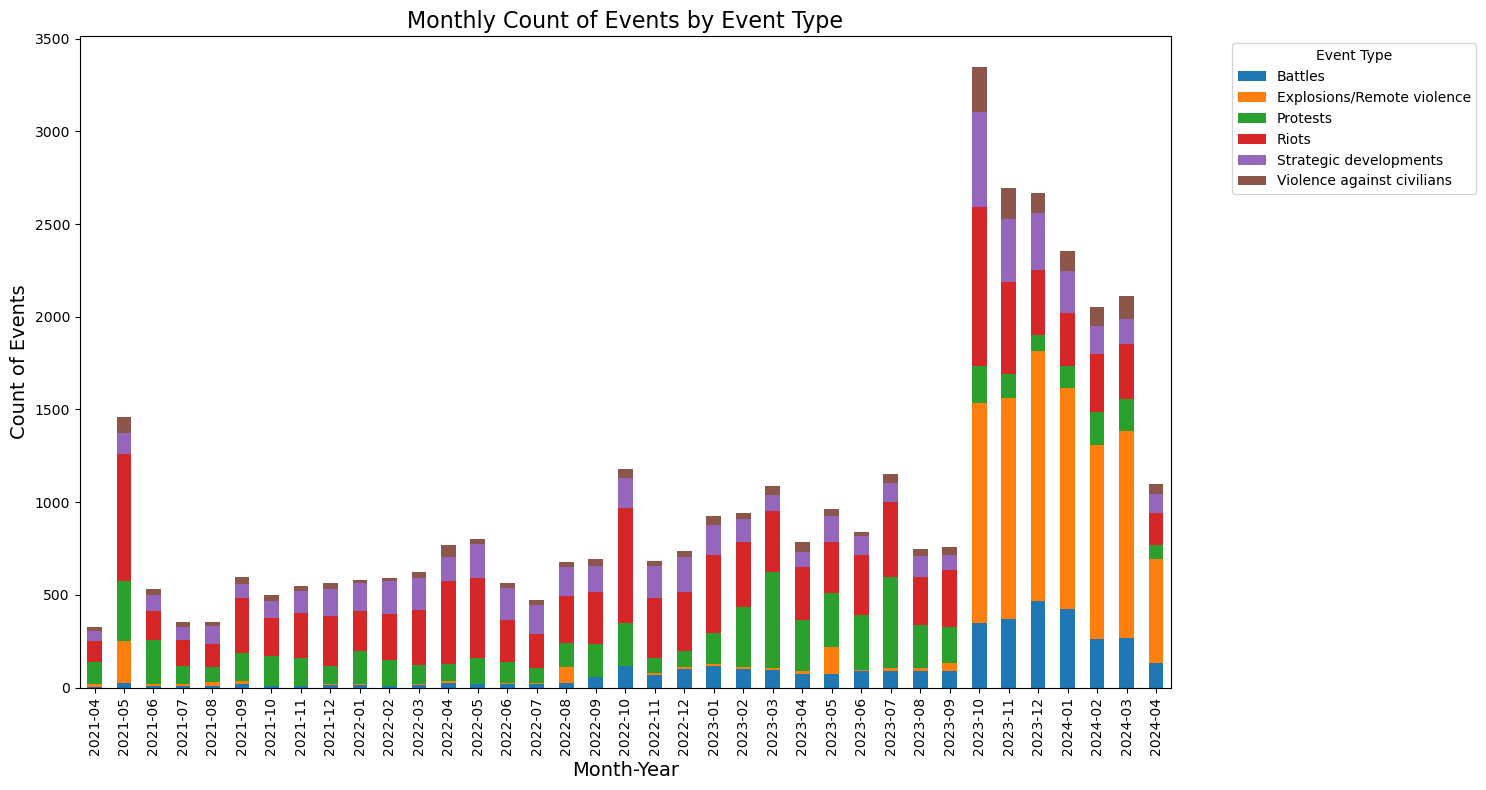

In [187]:
# Plotting the count of events over time by event_type
location_data['month_year'] = location_data['event_date'].dt.to_period('M') #group data into month

# countplot with monthly data
plt.figure(figsize=(15, 8))
monthly_data = location_data.groupby(['month_year', 'event_type']).size().reset_index(name='counts')

#creating'event_type' columns
monthly_pivot = monthly_data.pivot(index='month_year', columns='event_type', values='counts').fillna(0)

monthly_pivot.plot(kind='bar', stacked=True, figsize=(15, 8))
plt.title('Monthly Count of Events by Event Type', fontsize=16)
plt.xlabel('Month-Year', fontsize=14)
plt.ylabel('Count of Events', fontsize=14)
plt.xticks(rotation=90)
plt.legend(title='Event Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

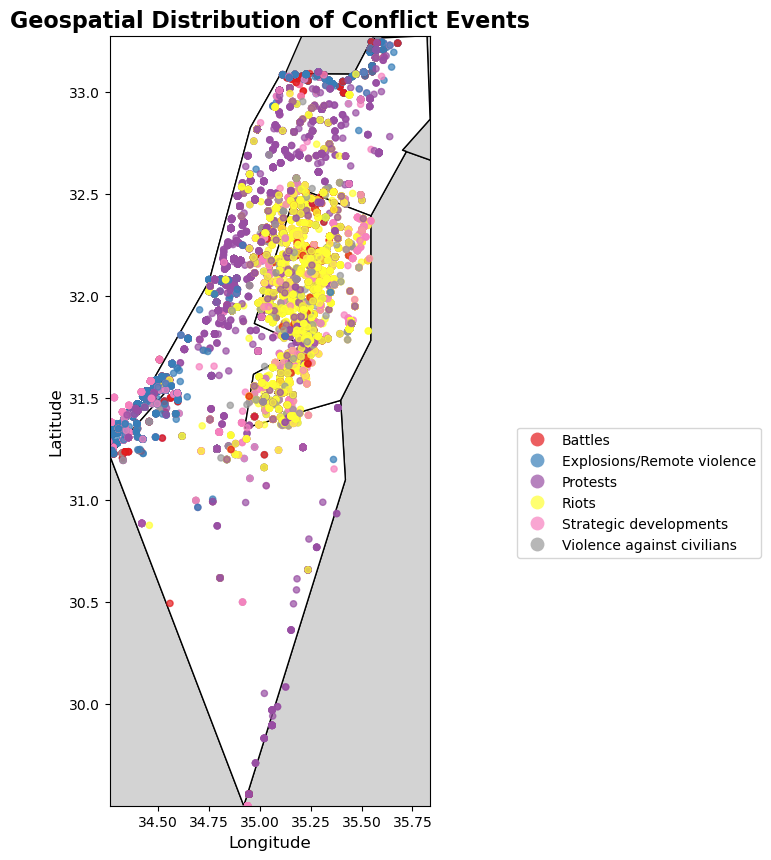

In [188]:
geometry = [Point(xy) for xy in zip(location_data.longitude, location_data.latitude)]
geo_df = gpd.GeoDataFrame(location_data, geometry=geometry)

fig, ax = plt.subplots(1, 1, figsize=(5, 10))

# Load a world map shapefile and plot the world in a light grey
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.plot(ax=ax, color='lightgrey', edgecolor='black')

# Plot Israel and Palestine with a clear edge
isr_pal = world[(world.name == "Israel") | (world.name == "Palestine")]
isr_pal.plot(ax=ax, color='white', edgecolor='black')

geo_df.plot(ax=ax, column='event_type', legend=True, markersize=20, cmap='Set1', alpha=0.7)

leg = ax.get_legend()
if leg:  
    leg.set_bbox_to_anchor((1.25, 0.5))

# Set the limits to frame the region of interest
plt.xlim(isr_pal.bounds.minx.min(), isr_pal.bounds.maxx.max())
plt.ylim(isr_pal.bounds.miny.min(), isr_pal.bounds.maxy.max())

# Set title and axis labels
plt.title('Geospatial Distribution of Conflict Events', fontsize=16, weight='bold')
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)

# Remove axis for a cleaner look
plt.axis('on')

# Show the plot
plt.show()

In [189]:
#log transformations
log_columns = ['fatalities', 'cumulative_sub_events', 'cumulative_fatalities', 'rolling_avg_fatalities_7d', 
               'time_since_last_event', 'time_since_last_disorder', 'days_since_start']
for col in log_columns:
    log_data['log_' + col] = np.log1p(log_data[col])

# creating lagged features
for col in log_columns:
    log_col = 'log_' + col
    for lag in [1, 2, 3]:
        log_data[f'{log_col}_lag{lag}'] = log_data[log_col].shift(lag)

In [190]:
log_data

,event_date,year,disorder_type,sub_event_type,actor1,inter1,actor2,inter2,interaction,civilian_targeting,...,log_rolling_avg_fatalities_7d_lag3,log_time_since_last_event_lag1,log_time_since_last_event_lag2,log_time_since_last_event_lag3,log_time_since_last_disorder_lag1,log_time_since_last_disorder_lag2,log_time_since_last_disorder_lag3,log_days_since_start_lag1,log_days_since_start_lag2,log_days_since_start_lag3
38129,2021-04-20,2021,Strategic developments,Looting/property destruction,Hamas Movement,3,Military Forces of Israel,8,38,Not specified,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
38117,2021-04-20,2021,Political violence,Mob violence,Rioters (Israel),5,Civilians (Palestine),7,57,Civilian targeting,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN
38118,2021-04-20,2021,Demonstrations,Peaceful protest,Protesters (Israel),6,Not specified,0,60,Not specified,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN
38119,2021-04-20,2021,Demonstrations,Peaceful protest,Protesters (Israel),6,Not specified,0,60,Not specified,...,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000
38120,2021-04-20,2021,Political violence,Attack,Police Forces of Israel,8,Civilians (Palestine),7,78,Civilian targeting,...,0.000000,0.0,NaN,NaN,0.0,NaN,NaN,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28,2024-04-19,2024,Political violence,Air/drone strike,Military Forces of Israel,8,Civilians (Palestine),7,78,Civilian targeting,...,0.133531,0.0,0.0,0.0,0.0,0.0,0.0,6.999422,6.999422,6.999422
27,2024-04-19,2024,Political violence,Air/drone strike,Military Forces of Israel,8,Not specified,0,80,Not specified,...,0.133531,0.0,0.0,0.0,0.0,0.0,0.0,6.999422,6.999422,6.999422
26,2024-04-19,2024,Political violence,Air/drone strike,Military Forces of Israel,8,Civilians (Palestine),7,78,Civilian targeting,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,6.999422,6.999422,6.999422
25,2024-04-19,2024,Political violence,Air/drone strike,Military Forces of Israel,8,Civilians (Palestine),7,78,Civilian targeting,...,0.826679,0.0,0.0,0.0,0.0,0.0,0.0,6.999422,6.999422,6.999422


In [191]:
print(log_data.isna().sum())

# percentage of zero values
zero_counts = (log_data == 0).astype(int).sum(axis=0)
zero_percentage = 100 * zero_counts / len(log_data)
print(zero_percentage[zero_percentage > 0])


event_date                             0
year                                   0
disorder_type                          0
sub_event_type                         0
actor1                                 0
inter1                                 0
actor2                                 0
inter2                                 0
interaction                            0
civilian_targeting                     0
country                                0
admin1                                 0
admin2                                 0
fatalities                             0
month                                  0
day                                    0
day_of_week                            0
days_since_start                       0
time_since_last_event                 20
time_since_last_disorder               4
rolling_avg_fatalities_7d              0
cumulative_sub_events                  0
cumulative_fatalities                  0
log_fatalities                         0
log_cumulative_s

In [192]:
#replacing infinities w NaN
log_data.replace([np.inf, -np.inf], np.nan, inplace=True)
#log_data.fillna(log_data.median(), inplace=True)

#median for numeric columns
numeric_medians = log_data.select_dtypes(include=[np.number]).median()
log_data.fillna(numeric_medians, inplace=True)


log_data['time_since_last_event'].fillna(method='ffill', inplace=True)
log_data['time_since_last_event'].fillna(method='bfill', inplace=True)

lag_cols = [col for col in log_data.columns if ('log_time_since_last_event' in col or 'lag' in col) and 
            np.issubdtype(log_data[col].dtype, np.number)]

In [193]:
print(log_data.shape)
print(log_data.isna().sum())

# percentage of zero values
zero_counts = (log_data == 0).astype(int).sum(axis=0)
zero_percentage = 100 * zero_counts / len(log_data)
print(zero_percentage[zero_percentage > 0])

(28252, 51)
event_date                            0
year                                  0
disorder_type                         0
sub_event_type                        0
actor1                                0
inter1                                0
actor2                                0
inter2                                0
interaction                           0
civilian_targeting                    0
country                               0
admin1                                0
admin2                                0
fatalities                            0
month                                 0
day                                   0
day_of_week                           0
days_since_start                      0
time_since_last_event                 0
time_since_last_disorder              0
rolling_avg_fatalities_7d             0
cumulative_sub_events                 0
cumulative_fatalities                 0
log_fatalities                        0
log_cumulative_sub_events   

In [194]:
threshold = 70

# columns where the percentage of zero is higher than threshold
columns_to_drop = zero_percentage[zero_percentage > threshold].index

# drop
log_data = log_data.drop(columns=columns_to_drop)

print("Columns dropped:", columns_to_drop)
print("Shape of the new DataFrame:", log_data.shape)

Columns dropped: Index(['fatalities', 'time_since_last_event', 'time_since_last_disorder',
       'log_fatalities', 'log_time_since_last_event',
       'log_time_since_last_disorder', 'log_fatalities_lag1',
       'log_fatalities_lag2', 'log_fatalities_lag3',
       'log_time_since_last_event_lag1', 'log_time_since_last_event_lag2',
       'log_time_since_last_event_lag3', 'log_time_since_last_disorder_lag1',
       'log_time_since_last_disorder_lag2',
       'log_time_since_last_disorder_lag3'],
      dtype='object')
Shape of the new DataFrame: (28252, 36)


In [195]:
print(log_data.dtypes)
unique_counts = log_data.nunique()
print(unique_counts)

event_date                            datetime64[ns]
year                                           int32
disorder_type                                 object
sub_event_type                                object
actor1                                        object
inter1                                         int64
actor2                                        object
inter2                                         int64
interaction                                    int64
civilian_targeting                            object
country                                       object
admin1                                        object
admin2                                        object
month                                          int32
day                                            int32
day_of_week                                   object
days_since_start                               int64
rolling_avg_fatalities_7d                    float64
cumulative_sub_events                         

In [196]:
#Encoding

#One-Hot for Categoricals
categorical_cols = ['disorder_type', 'sub_event_type', 'civilian_targeting',
                    'country', 'admin1', 'admin2', 'day_of_week', 'inter1', 'inter2', 'interaction']
log_data_encoded = pd.get_dummies(log_data, columns=categorical_cols)
log_data_encoded

#Label Encoder
label_encoders = {}

for col in ['actor1', 'actor2']:
    le = LabelEncoder()
    log_data_encoded[col] = le.fit_transform(log_data_encoded[col])
    label_encoders[col] = le  # storing the encoder
log_data_encoded.to_csv('data/log_data_encoded.csv', index=False)
#print(log_data_encoded.isna().sum())

log_data_encoded = log_data_encoded.apply(lambda col: col.astype(int) if pd.api.types.is_bool_dtype(col) else col) 
#SO IMPORTANT! changes values of bool to int

In [197]:
log_data_encoded

,event_date,year,actor1,actor2,month,day,days_since_start,rolling_avg_fatalities_7d,cumulative_sub_events,cumulative_fatalities,...,interaction_57,interaction_58,interaction_60,interaction_66,interaction_68,interaction_70,interaction_77,interaction_78,interaction_80,interaction_88
38129,2021-04-20,2021,3,7,4,20,0,0.000000,1,0,...,0,0,0,0,0,0,0,0,0,0
38117,2021-04-20,2021,19,2,4,20,0,0.000000,1,0,...,1,0,0,0,0,0,0,0,0,0
38118,2021-04-20,2021,17,9,4,20,0,0.000000,1,0,...,0,0,1,0,0,0,0,0,0,0
38119,2021-04-20,2021,17,9,4,20,0,0.000000,2,0,...,0,0,1,0,0,0,0,0,0,0
38120,2021-04-20,2021,14,2,4,20,0,0.000000,1,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28,2024-04-19,2024,8,2,4,19,1095,1.285714,3002,26163,...,0,0,0,0,0,0,0,1,0,0
27,2024-04-19,2024,8,9,4,19,1095,1.285714,3003,26163,...,0,0,0,0,0,0,0,0,1,0
26,2024-04-19,2024,8,2,4,19,1095,1.285714,3004,26163,...,0,0,0,0,0,0,0,1,0,0
25,2024-04-19,2024,8,2,4,19,1095,1.428571,3005,26164,...,0,0,0,0,0,0,0,1,0,0


In [198]:
print(log_data_encoded.dtypes)
unique_counts = log_data_encoded.nunique()
#print(unique_counts)

event_date        datetime64[ns]
year                       int32
actor1                     int64
actor2                     int64
month                      int32
                       ...      
interaction_70             int64
interaction_77             int64
interaction_78             int64
interaction_80             int64
interaction_88             int64
Length: 146, dtype: object


In [199]:
# Correlation Analysis for numerical cols
numerical_cols = log_data_encoded.select_dtypes(include=['int64', 'float64']).columns
numerical_data = log_data_encoded[numerical_cols]
correlation_matrix = numerical_data.corr()
correlation_matrix

threshold = 0.75
upper = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(np.bool_))
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
print(to_drop)
print(log_data_encoded.shape)

#dropping one of each pair of highly coor. vars at 75% up
log_data_encoded_dropped = log_data_encoded.drop(columns=to_drop)
print(f"Data shape after dropping highly correlated features: {log_data_encoded_dropped.shape}")

['log_cumulative_sub_events', 'log_rolling_avg_fatalities_7d', 'log_days_since_start', 'log_days_since_start_lag1', 'log_days_since_start_lag2', 'log_days_since_start_lag3', 'disorder_type_Political violence', 'sub_event_type_Air/drone strike', 'sub_event_type_Excessive force against protesters', 'sub_event_type_Peaceful protest', 'admin2_Beer Sheva', 'admin2_Jerusalem', 'admin2_Tel Aviv', 'inter1_5', 'inter1_6', 'interaction_12', 'interaction_27', 'interaction_38', 'interaction_47', 'interaction_55', 'interaction_60', 'interaction_66', 'interaction_70', 'interaction_78']
(28252, 146)
Data shape after dropping highly correlated features: (28252, 122)


In [200]:
# target columns
sub_event_type_columns = [col for col in log_data_encoded.columns if col.startswith('sub_event_type_')]

# taking out the features, datetime
features = log_data_encoded.drop(columns=['event_date'] + sub_event_type_columns)

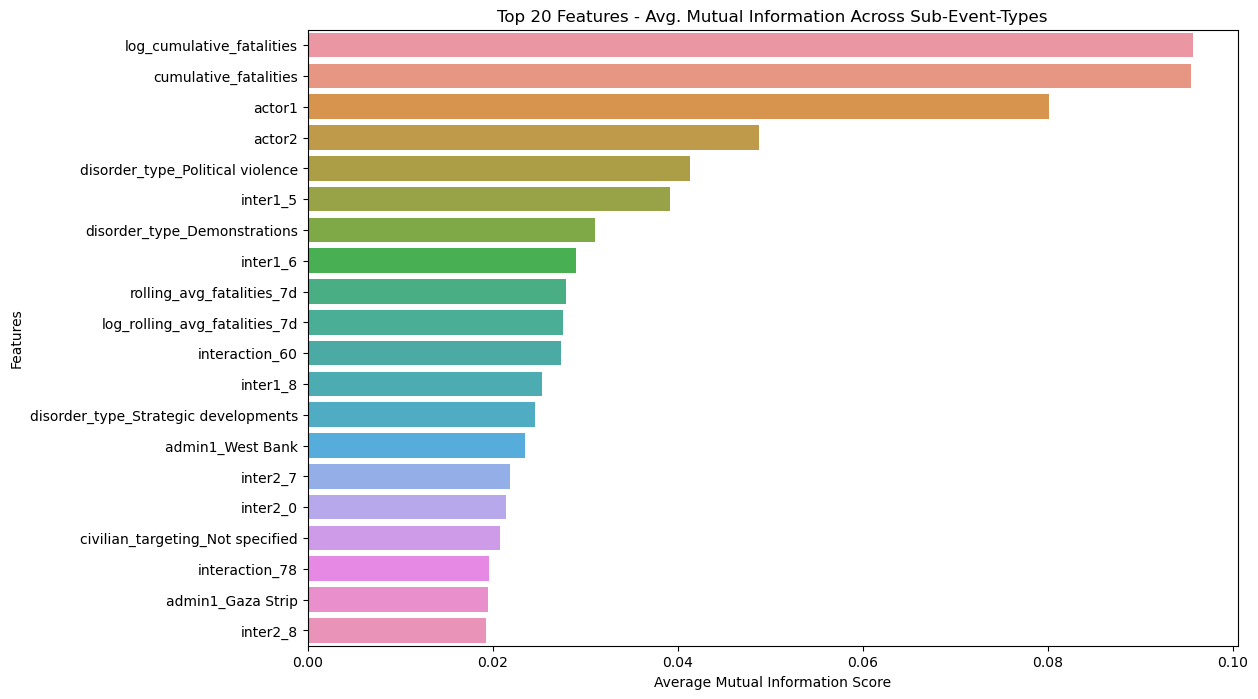

In [201]:
#Mututal Information features

# actual mi score calculation
mi_scores_df = pd.DataFrame()

for target in sub_event_type_columns:
    mi_scores = mutual_info_classif(features, log_data_encoded[target], discrete_features='auto')
    mi_scores_df[target] = mi_scores

#creating mi_scores + top 20 features shown below
mi_scores_df['average_mi_score'] = mi_scores_df.mean(axis=1)
mi_scores_df['feature'] = features.columns

#if 'feature' in mi_scores_df.columns:
    #top_features_mi = mi_scores_df.sort_values('average_mi_score', ascending=False).head(20)['feature'].tolist()
#else:
    #top_features_mi = mi_scores_df.sort_values('average_mi_score', ascending=False).head(20).index.tolist()

plt.figure(figsize=(12, 8))
sns.barplot(x='average_mi_score', y='feature', data=mi_scores_df.sort_values('average_mi_score', ascending=False).head(20))
plt.title('Top 20 Features - Avg. Mutual Information Across Sub-Event-Types')
plt.xlabel('Average Mutual Information Score')
plt.ylabel('Features')
plt.show()

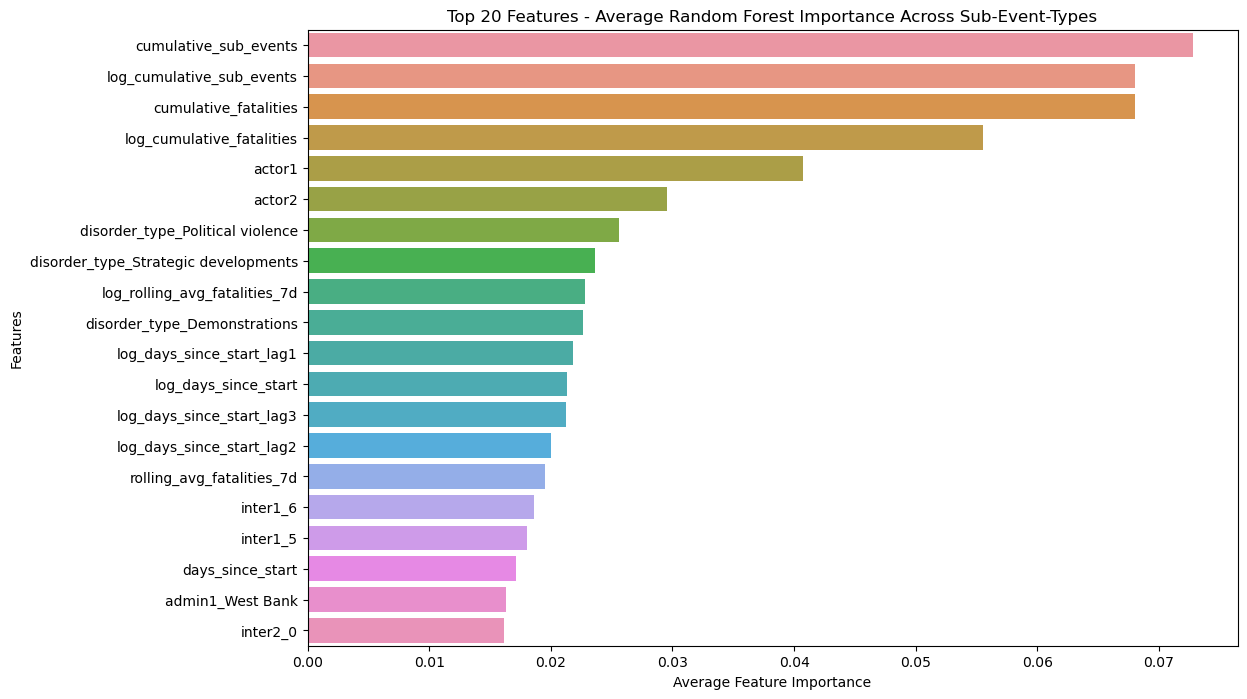

In [202]:
#Random Forest Importance

#feature importances
importances_df = pd.DataFrame(index=features.columns)

for target in sub_event_type_columns:
    X_train, X_test, y_train, y_test = train_test_split(features, log_data_encoded[target], test_size=0.2, random_state=42, shuffle=False)
    forest = RandomForestClassifier(random_state=42)
    forest.fit(X_train, y_train)
    importances_df[target] = forest.feature_importances_

# average feature importance across all sub_event_types
importances_df['average_importance'] = importances_df.mean(axis=1)

#if 'feature' in importances_df.columns:
#    top_features_rf = importances_df.sort_values('average_importance', ascending=False).head(20)['feature'].tolist()
#else:
#    top_features_rf = importances_df.sort_values('average_importance', ascending=False).head(20).index.tolist()


# average feature importances
plt.figure(figsize=(12, 8))
sorted_importances = importances_df['average_importance'].sort_values(ascending=False).head(20)
sns.barplot(x=sorted_importances.values, y=sorted_importances.index)
plt.title('Top 20 Features - Average Random Forest Importance Across Sub-Event-Types')
plt.xlabel('Average Feature Importance')
plt.ylabel('Features')
plt.show()

In [203]:
print(mi_scores_df.shape)
print(importances_df.shape)

(125, 22)
(125, 21)


In [209]:
# MI score
mi_percentile = 80  # aka keeping top 20%
mi_threshold = np.percentile(mi_scores_df['average_mi_score'], mi_percentile)
selected_mi_features = mi_scores_df[mi_scores_df['average_mi_score'] >= mi_threshold]['feature'].tolist()

# random forest importance
rf_percentile = 80  # aka keeping top 20% | top 30% is 43 features
rf_threshold = np.percentile(importances_df['average_importance'], rf_percentile)
selected_rf_features = importances_df[importances_df['average_importance'] >= rf_threshold].index.tolist()

#Combining into 1
selected_features = list(set(selected_mi_features) & set(selected_rf_features))
print(selected_features)

['disorder_type_Strategic developments', 'actor1', 'log_days_since_start', 'actor2', 'inter2_0', 'log_days_since_start_lag3', 'civilian_targeting_Not specified', 'inter1_3', 'log_days_since_start_lag1', 'log_rolling_avg_fatalities_7d', 'inter1_5', 'rolling_avg_fatalities_7d', 'admin1_West Bank', 'log_cumulative_fatalities', 'days_since_start', 'disorder_type_Demonstrations', 'admin1_Gaza Strip', 'disorder_type_Political violence', 'cumulative_fatalities', 'inter1_6']


In [227]:
print(len(selected_features))
print(len(set(selected_features))) #unique


20
20


In [228]:
#Checking Data Stats

Class Distribution:
sub_event_type_Abduction/forced disappearance          0.021237
sub_event_type_Agreement                               0.021237
sub_event_type_Air/drone strike                       10.636415
sub_event_type_Armed clash                            10.179810
sub_event_type_Arrests                                 0.286705
sub_event_type_Attack                                  6.353532
sub_event_type_Change to group/activity                0.700835
sub_event_type_Disrupted weapons use                   2.074189
sub_event_type_Excessive force against protesters      0.261928
sub_event_type_Government regains territory            0.007079
sub_event_type_Grenade                                 0.651281
sub_event_type_Looting/property destruction            6.870310
sub_event_type_Mob violence                           25.230072
sub_event_type_Non-state actor overtakes territory     0.010619
sub_event_type_Other                                   6.144698
sub_event_type_Peace

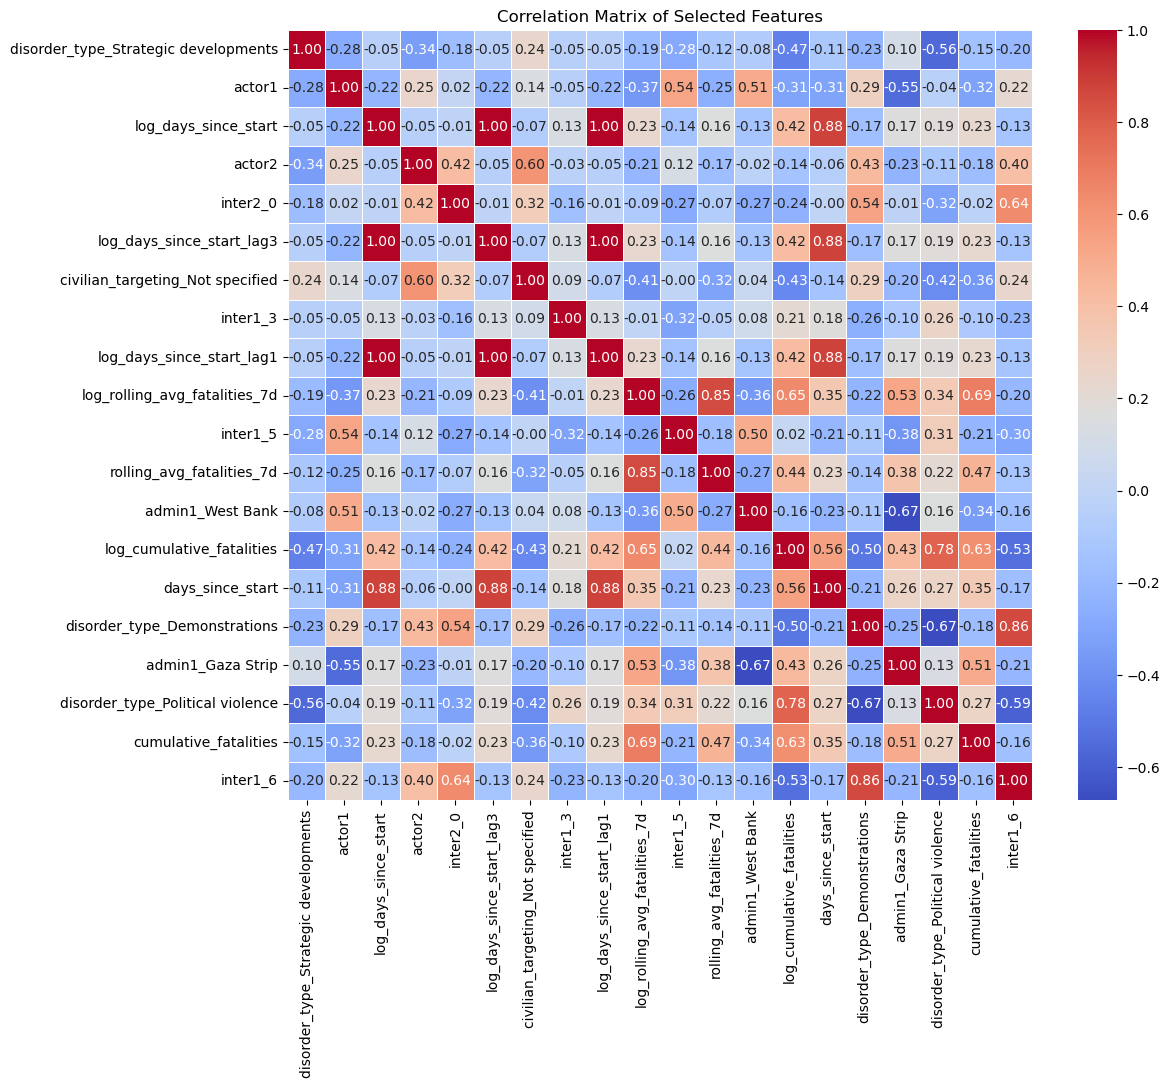

In [229]:
# Class Imbalance
sub_event_type_columns = [col for col in log_data_encoded.columns if col.startswith('sub_event_type_')]
class_counts = log_data_encoded[sub_event_type_columns].sum()
class_percentages = class_counts / len(log_data_encoded) * 100
print("Class Distribution:")
print(class_percentages)

# Multicollinearity
selected_data = log_data_encoded[selected_features]
correlation_matrix = selected_data.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation Matrix of Selected Features")
plt.show()

The following code shows us that there are a few features with high class imbalances: 5 values above 9%
We also have a few features that have a high correlation such as 'log_days_since_start_lag' 1 2 and 3 all have a correlation of 1.0 indicating the presence of multicollinearity. 

In [230]:
def test_stationarity(timeseries):
    # ADF test
    adf_result = adfuller(timeseries)
    print(f"ADF Statistic: {adf_result[0]}")
    print(f"p-value: {adf_result[1]}")
    
    # KPSS test
    kpss_result = kpss(timeseries)
    print(f"KPSS Statistic: {kpss_result[0]}")
    print(f"p-value: {kpss_result[1]}")

for col in selected_features:
    print(f"Stationarity Test for {col}:")
    test_stationarity(log_data_encoded[col])
    print()

Stationarity Test for disorder_type_Strategic developments:
ADF Statistic: -16.040629327255946
p-value: 5.919405431313334e-29
KPSS Statistic: 15.251725858298274
p-value: 0.01

Stationarity Test for actor1:


/var/folders/8v/6fds7wl53y707fgtm7_zvjm80000gp/T/ipykernel_1877/2492474057.py:8: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(timeseries)


ADF Statistic: -8.86162822032417
p-value: 1.4775316401192507e-14
KPSS Statistic: 23.90517730009339
p-value: 0.01

Stationarity Test for log_days_since_start:


/var/folders/8v/6fds7wl53y707fgtm7_zvjm80000gp/T/ipykernel_1877/2492474057.py:8: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(timeseries)


ADF Statistic: -21.71156693287082
p-value: 0.0
KPSS Statistic: 18.25286684466152
p-value: 0.01

Stationarity Test for actor2:


/var/folders/8v/6fds7wl53y707fgtm7_zvjm80000gp/T/ipykernel_1877/2492474057.py:8: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(timeseries)


ADF Statistic: -16.731393601337686
p-value: 1.3821609593477742e-29
KPSS Statistic: 6.1599406817822375
p-value: 0.01

Stationarity Test for inter2_0:


/var/folders/8v/6fds7wl53y707fgtm7_zvjm80000gp/T/ipykernel_1877/2492474057.py:8: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(timeseries)


ADF Statistic: -36.609340507498274
p-value: 0.0
KPSS Statistic: 0.8160568961717696
p-value: 0.01

Stationarity Test for log_days_since_start_lag3:


/var/folders/8v/6fds7wl53y707fgtm7_zvjm80000gp/T/ipykernel_1877/2492474057.py:8: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(timeseries)


ADF Statistic: -21.736751798754387
p-value: 0.0
KPSS Statistic: 18.25049794739106
p-value: 0.01

Stationarity Test for civilian_targeting_Not specified:


/var/folders/8v/6fds7wl53y707fgtm7_zvjm80000gp/T/ipykernel_1877/2492474057.py:8: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(timeseries)


ADF Statistic: -13.70117327677458
p-value: 1.288847729226622e-25
KPSS Statistic: 21.267571538663727
p-value: 0.01

Stationarity Test for inter1_3:


/var/folders/8v/6fds7wl53y707fgtm7_zvjm80000gp/T/ipykernel_1877/2492474057.py:8: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(timeseries)


ADF Statistic: -14.589945930043617
p-value: 4.330616973357374e-27
KPSS Statistic: 28.39159962699679
p-value: 0.01

Stationarity Test for log_days_since_start_lag1:


/var/folders/8v/6fds7wl53y707fgtm7_zvjm80000gp/T/ipykernel_1877/2492474057.py:8: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(timeseries)


ADF Statistic: -21.933231310380144
p-value: 0.0
KPSS Statistic: 18.25210651672467
p-value: 0.01

Stationarity Test for log_rolling_avg_fatalities_7d:


/var/folders/8v/6fds7wl53y707fgtm7_zvjm80000gp/T/ipykernel_1877/2492474057.py:8: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(timeseries)


ADF Statistic: -8.585712841975262
p-value: 7.517374719304192e-14
KPSS Statistic: 21.315326181886878
p-value: 0.01

Stationarity Test for inter1_5:


/var/folders/8v/6fds7wl53y707fgtm7_zvjm80000gp/T/ipykernel_1877/2492474057.py:8: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(timeseries)


ADF Statistic: -12.56141579998013
p-value: 2.0985350234908663e-23
KPSS Statistic: 26.4033832640823
p-value: 0.01

Stationarity Test for rolling_avg_fatalities_7d:


/var/folders/8v/6fds7wl53y707fgtm7_zvjm80000gp/T/ipykernel_1877/2492474057.py:8: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(timeseries)


ADF Statistic: -14.53744548314206
p-value: 5.211250919162529e-27
KPSS Statistic: 13.402199120352824
p-value: 0.01

Stationarity Test for admin1_West Bank:


/var/folders/8v/6fds7wl53y707fgtm7_zvjm80000gp/T/ipykernel_1877/2492474057.py:8: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(timeseries)


ADF Statistic: -12.784549070852114
p-value: 7.294002601329369e-24
KPSS Statistic: 22.671058679138742
p-value: 0.01

Stationarity Test for log_cumulative_fatalities:


/var/folders/8v/6fds7wl53y707fgtm7_zvjm80000gp/T/ipykernel_1877/2492474057.py:8: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(timeseries)


ADF Statistic: -5.074658030079506
p-value: 1.576063548372852e-05
KPSS Statistic: 27.497229505058357
p-value: 0.01

Stationarity Test for days_since_start:


/var/folders/8v/6fds7wl53y707fgtm7_zvjm80000gp/T/ipykernel_1877/2492474057.py:8: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(timeseries)


ADF Statistic: -12.781355335995366
p-value: 7.403729714320849e-24
KPSS Statistic: 27.3458485907781
p-value: 0.01

Stationarity Test for disorder_type_Demonstrations:


/var/folders/8v/6fds7wl53y707fgtm7_zvjm80000gp/T/ipykernel_1877/2492474057.py:8: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(timeseries)


ADF Statistic: -13.500576985460892
p-value: 2.9825356893457593e-25
KPSS Statistic: 17.741149528402982
p-value: 0.01

Stationarity Test for admin1_Gaza Strip:


/var/folders/8v/6fds7wl53y707fgtm7_zvjm80000gp/T/ipykernel_1877/2492474057.py:8: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(timeseries)


ADF Statistic: -9.703117671080607
p-value: 1.059160715999903e-16
KPSS Statistic: 23.026164021344872
p-value: 0.01

Stationarity Test for disorder_type_Political violence:


/var/folders/8v/6fds7wl53y707fgtm7_zvjm80000gp/T/ipykernel_1877/2492474057.py:8: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(timeseries)


ADF Statistic: -10.458451645543066
p-value: 1.3789295167541213e-18
KPSS Statistic: 25.317794785408232
p-value: 0.01

Stationarity Test for cumulative_fatalities:


/var/folders/8v/6fds7wl53y707fgtm7_zvjm80000gp/T/ipykernel_1877/2492474057.py:8: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(timeseries)


ADF Statistic: -6.529160950413836
p-value: 9.969972209061724e-09
KPSS Statistic: 24.96437504288526
p-value: 0.01

Stationarity Test for inter1_6:


/var/folders/8v/6fds7wl53y707fgtm7_zvjm80000gp/T/ipykernel_1877/2492474057.py:8: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(timeseries)


ADF Statistic: -13.70643818910814
p-value: 1.2612161463875373e-25
KPSS Statistic: 15.619748984908377
p-value: 0.01



/var/folders/8v/6fds7wl53y707fgtm7_zvjm80000gp/T/ipykernel_1877/2492474057.py:8: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(timeseries)


P-Values are almost all near 0 indicating that we can reject the null hypothesis of non-stationarity. Suggests that the selected features are likely stationary which is what we want!

In [231]:
def test_heteroscedasticity(y, X):
    X_const = add_constant(X)
    
    # Breusch-Pagan test
    bp_result = het_breuschpagan(y, X_const)
    print(f"Breusch-Pagan Statistic: {bp_result[0]}")
    print(f"p-value: {bp_result[1]}")

In [232]:
X = log_data_encoded[selected_features]

for col in sub_event_type_columns:
    print(f"Heteroscedasticity Test for {col}:")
    y = log_data_encoded[col]
    test_heteroscedasticity(y, X)
    print()

Heteroscedasticity Test for sub_event_type_Abduction/forced disappearance:
Breusch-Pagan Statistic: 323.6625029300653
p-value: 1.1589485958389722e-56

Heteroscedasticity Test for sub_event_type_Agreement:
Breusch-Pagan Statistic: 114.0744272818891
p-value: 3.5292445398490342e-15

Heteroscedasticity Test for sub_event_type_Air/drone strike:
Breusch-Pagan Statistic: 23531.535820869518
p-value: 0.0

Heteroscedasticity Test for sub_event_type_Armed clash:
Breusch-Pagan Statistic: 16655.233552514805
p-value: 0.0

Heteroscedasticity Test for sub_event_type_Arrests:
Breusch-Pagan Statistic: 656.4979886172143
p-value: 3.4783753806352993e-126

Heteroscedasticity Test for sub_event_type_Attack:
Breusch-Pagan Statistic: 14089.83164813824
p-value: 0.0

Heteroscedasticity Test for sub_event_type_Change to group/activity:
Breusch-Pagan Statistic: 4155.937114976701
p-value: 0.0

Heteroscedasticity Test for sub_event_type_Disrupted weapons use:
Breusch-Pagan Statistic: 8676.394798409461
p-value: 0.0



Indication of heteroskedasticity due to p-values < 0.05 + extremely large BP stat! - Non Constant Variance throughout observations

In [233]:
X = sm.add_constant(log_data_encoded[selected_features])

for col in sub_event_type_columns:
    print(f"OLS Regression with Robust Standard Errors for {col}")
    y = log_data_encoded[col]
    model = sm.OLS(y, X)
    results = model.fit(cov_type='HC1')  # 'HC1' for robust standard errors
    print(results.summary())
    print("\n")

OLS Regression with Robust Standard Errors for sub_event_type_Abduction/forced disappearance
                                          OLS Regression Results                                         
Dep. Variable:     sub_event_type_Abduction/forced disappearance   R-squared:                       0.011
Model:                                                       OLS   Adj. R-squared:                  0.011
Method:                                            Least Squares   F-statistic:                    0.3065
Date:                                           Wed, 01 May 2024   Prob (F-statistic):              0.999
Time:                                                   19:01:24   Log-Likelihood:                 79544.
No. Observations:                                          28252   AIC:                        -1.590e+05
Df Residuals:                                              28231   BIC:                        -1.589e+05
Df Model:                                                  

In [234]:
for col in sub_event_type_columns:
    print(f"RLM Regression for {col}")
    y = log_data_encoded[col]
    
    # Initialize RLM with HuberT norm for robustness
    model_rlm = sm.RLM(y, X, M=sm.robust.norms.HuberT())
    results_rlm = model_rlm.fit()
    
    print(results_rlm.summary())
    print("\n")

RLM Regression for sub_event_type_Abduction/forced disappearance
                                  Robust linear Model Regression Results                                 
Dep. Variable:     sub_event_type_Abduction/forced disappearance   No. Observations:                28252
Model:                                                       RLM   Df Residuals:                    28231
Method:                                                     IRLS   Df Model:                           20
Norm:                                                     HuberT                                         
Scale Est.:                                                  mad                                         
Cov Type:                                                     H1                                         
Date:                                           Wed, 01 May 2024                                         
Time:                                                   19:01:26                       

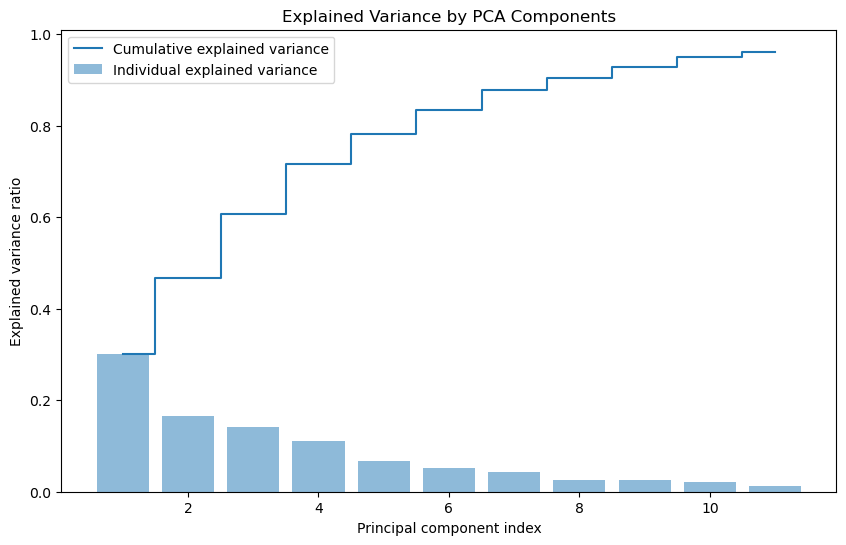

In [249]:
# standardizing
scaler = StandardScaler()
features_scaled = scaler.fit_transform(log_data_encoded[selected_features])

# attempt to fix Multicollinearity with PCA
pca = PCA(n_components=0.95)  # Retain 95% of variance
X_pca = pca.fit_transform(features_scaled)

explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(1, len(cumulative_variance) + 1), cumulative_variance, where='mid', label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.title('Explained Variance by PCA Components')
plt.legend(loc='best')
plt.show()

In [30]:
#Selected Features
X_selected = log_data_encoded[selected_features].copy()
y = np.argmax(log_data_encoded[sub_event_type_columns].values, axis=1)

X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42, shuffle=False)

y_train_encoded = tf.keras.utils.to_categorical(y_train)
y_test_encoded = tf.keras.utils.to_categorical(y_test)

In [31]:
#X_train = X_train.astype({col: 'int64' for col in X_train.columns if X_train[col].dtype == 'bool'})
#X_test = X_test.astype({col: 'int64' for col in X_test.columns if X_test[col].dtype == 'bool'})
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
print("Encoded Y")
print(y_train_encoded.shape)
print(y_test_encoded.shape)
print(y_train_encoded.dtype)
print(y_test_encoded.dtype)
#print(X_train.dtypes)

(30472, 24)
(7618, 24)
(30472,)
(7618,)
Encoded Y
(30472, 20)
(7618, 20)
float32
float32


In [32]:
#print(X_selected_train.head())
#print(y_train.head())
#print(y_train_encoded)

In [34]:
#Decision Tree Baseline

tree_classifier = DecisionTreeClassifier(random_state=42)

tree_classifier.fit(X_train, y_train_encoded)

tree_predictions = tree_classifier.predict(X_test)

tree_accuracy = accuracy_score(y_test_encoded, tree_predictions)
tree_classification_report = classification_report(y_test_encoded, tree_predictions)
print(f"Accuracy of Decision Tree: {tree_accuracy:.2f}")
print(tree_classification_report)

Accuracy of Decision Tree: 0.92
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         1
           2       0.84      0.74      0.78       152
           3       1.00      1.00      1.00       161
           4       0.09      0.29      0.14        14
           5       1.00      1.00      1.00       440
           6       0.96      0.86      0.91        64
           7       0.53      0.41      0.46        44
           8       1.00      1.00      1.00       108
           9       0.00      0.00      0.00         0
          10       0.12      0.50      0.20         2
          11       0.81      0.27      0.40       564
          12       1.00      1.00      1.00      2720
          13       0.00      0.00      0.00         0
          14       0.66      0.98      0.79       752
          15       1.00      1.00      1.00      1519
          16       1.00      0.99      0.99      

/Users/Arya/miniforge3/envs/venv-metal/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Arya/miniforge3/envs/venv-metal/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [35]:
# Logistic Regression
logistic_regressor = LogisticRegression(max_iter=1000, random_state=42)

logistic_regressor.fit(X_train, y_train)

logistic_predictions = logistic_regressor.predict(X_test)

logistic_accuracy = accuracy_score(y_test, logistic_predictions)
logistic_classification_report = classification_report(y_test, logistic_predictions)

print(f"Accuracy of Logistic Regression Baseline: {logistic_accuracy:.2f}")
print(logistic_classification_report)

Accuracy of Logistic Regression Baseline: 0.53
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00       152
           3       0.14      0.17      0.15       161
           4       0.00      0.00      0.00        14
           5       0.00      0.00      0.00       440
           6       0.00      0.00      0.00        64
           7       0.00      0.00      0.00        44
           8       0.00      0.00      0.00       108
          10       0.00      1.00      0.01         2
          11       0.00      0.00      0.00       564
          12       0.52      1.00      0.68      2720
          14       0.00      0.00      0.00       752
          15       0.90      0.86      0.88      1519
          16       0.00      0.00      0.00       281
          17       0.00      0.00      0.00         7
          18       0.00      0.00      0.00       163
          19       0.00      0.00 

/Users/Arya/miniforge3/envs/venv-metal/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/Arya/miniforge3/envs/venv-metal/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Arya/miniforge3/envs/venv-metal/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetric

In [36]:
#X_train = X_train.astype('float32')
#X_test = X_test.astype('float32')
#y_train_encoded = y_train_encoded.astype('float32')
#y_test_encoded = y_test_encoded.astype('float32')


In [37]:
#X_selected_train.dtypes

In [38]:
#Selected Features FOR LSTM
X_selected = log_data_encoded[selected_features].copy()
y = np.argmax(log_data_encoded[sub_event_type_columns].values, axis=1)

X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42, shuffle=False)

y_train_encoded = tf.keras.utils.to_categorical(y_train)
y_test_encoded = tf.keras.utils.to_categorical(y_test)

# Proper format for data
def create_sequences(data, n_steps):
    X = []
    for i in range(len(data) - n_steps + 1):
        X.append(data[i:i + n_steps])
    return np.array(X)

# Reshape X_train and X_test to include timesteps
n_steps = 24  # Number of timesteps
X_train_reshaped = create_sequences(X_train.to_numpy(), n_steps)
X_test_reshaped = create_sequences(X_test.to_numpy(), n_steps)

# Align the number of samples in y_train_encoded and y_test_encoded
y_train_encoded = y_train_encoded[:len(X_train_reshaped)]
y_test_encoded = y_test_encoded[:len(X_test_reshaped)]

In [39]:
#Grid Search for Hyperparameters - LSTM
def create_model(n_steps, n_features, n_nodes, dropout_rate, n_classes):
    model = Sequential()
    model.add(LSTM(n_nodes, input_shape=(n_steps, n_features), return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(n_nodes))
    model.add(Dropout(dropout_rate))
    model.add(Dense(n_classes, activation='softmax'))
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# [time steps, # of features per time step, neurons, dropout rate, output class]
configs = [
    [24, X_train_reshaped.shape[2], 50, 0.1, 20], #Testing 10% dropout and 50 neurons, 24 time steps
    [24, X_train_reshaped.shape[2], 50, 0.2, 20], #Testing 20% dropout and 50 neurons, 24 time steps
    [24, X_train_reshaped.shape[2], 100, 0.2, 20], #testing 20% dropout and 100 neurons, 24 time steps
    [24, X_train_reshaped.shape[2], 100, 0.3, 20], #testing 30% dropout and 100 neurons, 24 time steps
]

# run model with configs
def run_model(config):
    n_steps, n_features, n_nodes, dropout_rate, n_classes = config
    model = create_model(n_steps, n_features, n_nodes, dropout_rate, n_classes)
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = model.fit(X_train_reshaped, y_train_encoded, epochs=50, batch_size=64, validation_split=0.1, verbose=1, callbacks=[early_stopping])
    _, accuracy = model.evaluate(X_test_reshaped, y_test_encoded, verbose=0)
    return accuracy

# Grid search over configs
best_accuracy = 0
best_config = None
for config in configs:
    accuracy = run_model(config)
    print(f'Config: {config}, Accuracy: {accuracy:.3f}')
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_config = config

print(f'Best Config: {best_config}, Best Accuracy: {best_accuracy:.3f}')

2024-05-01 17:14:30.375803: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-05-01 17:14:30.375951: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-05-01 17:14:30.375961: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-05-01 17:14:30.376356: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-05-01 17:14:30.376791: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/50


2024-05-01 17:14:32.441788: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-01 17:14:32.627570: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-01 17:14:32.794322: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-01 17:14:32.951296: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  4/429 [..............................] - ETA: 9s - loss: 2.8979 - accuracy: 0.0820   

2024-05-01 17:14:33.078364: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


429/429 [==============================] - ETA: 0s - loss: 1.5955 - accuracy: 0.4541

2024-05-01 17:14:42.195578: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-01 17:14:42.258666: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-01 17:14:42.419987: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


429/429 [==============================] - 12s 23ms/step - loss: 1.5955 - accuracy: 0.4541 - val_loss: 1.4274 - val_accuracy: 0.4348
Epoch 2/50
429/429 [==============================] - 9s 21ms/step - loss: 1.1801 - accuracy: 0.5563 - val_loss: 1.9259 - val_accuracy: 0.3741
Epoch 3/50
429/429 [==============================] - 8s 20ms/step - loss: 1.0231 - accuracy: 0.5883 - val_loss: 1.3051 - val_accuracy: 0.4818
Epoch 4/50
429/429 [==============================] - 9s 20ms/step - loss: 0.8889 - accuracy: 0.6396 - val_loss: 1.2832 - val_accuracy: 0.5284
Epoch 5/50
429/429 [==============================] - 10s 23ms/step - loss: 0.7717 - accuracy: 0.6791 - val_loss: 1.4173 - val_accuracy: 0.5803
Epoch 6/50
429/429 [==============================] - 9s 21ms/step - loss: 0.7083 - accuracy: 0.6971 - val_loss: 1.0794 - val_accuracy: 0.6319
Epoch 7/50
429/429 [==============================] - 11s 24ms/step - loss: 0.6533 - accuracy: 0.7161 - val_loss: 1.0288 - val_accuracy: 0.6447
Epoch 8

2024-05-01 17:16:38.261330: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-01 17:16:38.538751: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-01 17:16:38.836805: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-01 17:16:39.146127: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  1/429 [..............................] - ETA: 30:53 - loss: 2.9517 - accuracy: 0.0000e+00

2024-05-01 17:16:39.487982: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


429/429 [==============================] - ETA: 0s - loss: 1.7806 - accuracy: 0.3825

2024-05-01 17:16:50.043485: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-01 17:16:50.119033: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-01 17:16:50.287200: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


429/429 [==============================] - 16s 26ms/step - loss: 1.7806 - accuracy: 0.3825 - val_loss: 2.3936 - val_accuracy: 0.2775
Epoch 2/50
429/429 [==============================] - 10s 23ms/step - loss: 1.2504 - accuracy: 0.5466 - val_loss: 2.4466 - val_accuracy: 0.3537
Epoch 3/50
429/429 [==============================] - 9s 20ms/step - loss: 0.9963 - accuracy: 0.6087 - val_loss: 1.2101 - val_accuracy: 0.5947
Epoch 4/50
429/429 [==============================] - 8s 19ms/step - loss: 0.8943 - accuracy: 0.6356 - val_loss: 1.9964 - val_accuracy: 0.4361
Epoch 5/50
429/429 [==============================] - 8s 19ms/step - loss: 0.8025 - accuracy: 0.6568 - val_loss: 1.3616 - val_accuracy: 0.5672
Epoch 6/50
429/429 [==============================] - 9s 20ms/step - loss: 0.7386 - accuracy: 0.6815 - val_loss: 3.0380 - val_accuracy: 0.3090
Epoch 7/50
429/429 [==============================] - 9s 20ms/step - loss: 0.7066 - accuracy: 0.6910 - val_loss: 2.1362 - val_accuracy: 0.4693
Epoch 8/

2024-05-01 17:20:36.959510: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-01 17:20:37.138850: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-01 17:20:37.229838: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-01 17:20:37.356142: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  1/429 [..............................] - ETA: 10:38 - loss: 3.0053 - accuracy: 0.0469

2024-05-01 17:20:37.484966: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


429/429 [==============================] - ETA: 0s - loss: 1.4544 - accuracy: 0.4791

2024-05-01 17:20:49.771678: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-01 17:20:49.832854: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-01 17:20:49.904521: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


429/429 [==============================] - 15s 31ms/step - loss: 1.4544 - accuracy: 0.4791 - val_loss: 1.0295 - val_accuracy: 0.5875
Epoch 2/50
429/429 [==============================] - 11s 26ms/step - loss: 0.8461 - accuracy: 0.6488 - val_loss: 0.7966 - val_accuracy: 0.6814
Epoch 3/50
429/429 [==============================] - 12s 29ms/step - loss: 0.7013 - accuracy: 0.6948 - val_loss: 0.7107 - val_accuracy: 0.6627
Epoch 4/50
429/429 [==============================] - 11s 26ms/step - loss: 0.6386 - accuracy: 0.7133 - val_loss: 0.6383 - val_accuracy: 0.7044
Epoch 5/50
429/429 [==============================] - 11s 25ms/step - loss: 0.5851 - accuracy: 0.7345 - val_loss: 0.5145 - val_accuracy: 0.7924
Epoch 6/50
429/429 [==============================] - 12s 28ms/step - loss: 0.5503 - accuracy: 0.7532 - val_loss: 0.9661 - val_accuracy: 0.6624
Epoch 7/50
429/429 [==============================] - 12s 27ms/step - loss: 0.5269 - accuracy: 0.7583 - val_loss: 0.3604 - val_accuracy: 0.8542
Epo

2024-05-01 17:24:10.668267: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-01 17:24:10.819986: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-01 17:24:10.901414: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-01 17:24:11.020622: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  3/429 [..............................] - ETA: 13s - loss: 3.0775 - accuracy: 0.0312 

2024-05-01 17:24:11.134666: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


429/429 [==============================] - ETA: 0s - loss: 1.4822 - accuracy: 0.4806

2024-05-01 17:24:21.072665: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-01 17:24:21.187855: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-01 17:24:21.240331: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


429/429 [==============================] - 12s 25ms/step - loss: 1.4822 - accuracy: 0.4806 - val_loss: 2.7507 - val_accuracy: 0.3760
Epoch 2/50
429/429 [==============================] - 11s 26ms/step - loss: 0.9334 - accuracy: 0.6248 - val_loss: 1.6649 - val_accuracy: 0.5048
Epoch 3/50
429/429 [==============================] - 10s 23ms/step - loss: 0.7846 - accuracy: 0.6659 - val_loss: 0.9261 - val_accuracy: 0.6509
Epoch 4/50
429/429 [==============================] - 10s 24ms/step - loss: 0.7386 - accuracy: 0.6807 - val_loss: 0.8260 - val_accuracy: 0.7008
Epoch 5/50
429/429 [==============================] - 9s 22ms/step - loss: 0.6770 - accuracy: 0.7038 - val_loss: 1.1346 - val_accuracy: 0.6066
Epoch 6/50
429/429 [==============================] - 10s 24ms/step - loss: 0.6481 - accuracy: 0.7145 - val_loss: 1.2240 - val_accuracy: 0.5619
Epoch 7/50
429/429 [==============================] - 9s 21ms/step - loss: 0.6449 - accuracy: 0.7154 - val_loss: 0.6122 - val_accuracy: 0.7498
Epoch

In [40]:
# Retraining Actual Model
def create_model(n_steps, n_features, n_nodes, dropout_rate, n_classes):
    model = Sequential()
    model.add(LSTM(n_nodes, input_shape=(n_steps, n_features), return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(n_nodes))
    model.add(Dropout(dropout_rate))
    model.add(Dense(n_classes, activation='softmax'))
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# best parameters
best_params = best_config

# model using the best parameters
LSTM_model_best = create_model(*best_params)

# early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = LSTM_model_best.fit(X_train_reshaped, y_train_encoded, epochs=50, batch_size=64,
                              validation_split=0.1, verbose=1, callbacks=[early_stopping])

Epoch 1/50


2024-05-01 17:27:33.696735: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-01 17:27:33.856486: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-01 17:27:33.945330: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-01 17:27:34.088348: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  1/429 [..............................] - ETA: 9:30 - loss: 2.9814 - accuracy: 0.0469

2024-05-01 17:27:34.197782: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


429/429 [==============================] - ETA: 0s - loss: 1.5276 - accuracy: 0.4579

2024-05-01 17:27:43.167291: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-01 17:27:43.228820: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-01 17:27:43.288701: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


429/429 [==============================] - 11s 23ms/step - loss: 1.5276 - accuracy: 0.4579 - val_loss: 2.7552 - val_accuracy: 0.2920
Epoch 2/50
429/429 [==============================] - 9s 20ms/step - loss: 0.9623 - accuracy: 0.6175 - val_loss: 1.2402 - val_accuracy: 0.5195
Epoch 3/50
429/429 [==============================] - 9s 22ms/step - loss: 0.7603 - accuracy: 0.6734 - val_loss: 1.1644 - val_accuracy: 0.5356
Epoch 4/50
429/429 [==============================] - 11s 26ms/step - loss: 0.6783 - accuracy: 0.7013 - val_loss: 0.5852 - val_accuracy: 0.7619
Epoch 5/50
429/429 [==============================] - 11s 26ms/step - loss: 0.6457 - accuracy: 0.7176 - val_loss: 1.5015 - val_accuracy: 0.5970
Epoch 6/50
429/429 [==============================] - 9s 22ms/step - loss: 0.6175 - accuracy: 0.7287 - val_loss: 0.5220 - val_accuracy: 0.8076
Epoch 7/50
429/429 [==============================] - 9s 22ms/step - loss: 0.5941 - accuracy: 0.7431 - val_loss: 0.4876 - val_accuracy: 0.8217
Epoch 8

In [41]:
# Evaluation
test_loss, test_accuracy = LSTM_model_best.evaluate(X_test_reshaped, y_test_encoded, verbose=0)
print(f'Test Accuracy LSTM: {test_accuracy:.3f}')

# Predictions
y_pred_LSTM = LSTM_model_best.predict(X_test_reshaped)
y_pred_classes_LSTM = np.argmax(y_pred_LSTM, axis=1)  # Convert probabilities to class labels

# Actual classes
actual_classes_LSTM = np.argmax(y_test_encoded, axis=1) if y_test_encoded.ndim > 1 else y_test

# Metrics
mae_LSTM = mean_absolute_error(actual_classes_LSTM, y_pred_classes_LSTM)
print(f'Mean Absolute Error LSTM: {mae_LSTM:.2f}')

mse_LSTM = mean_squared_error(actual_classes_LSTM, y_pred_classes_LSTM)
print(f'Mean Squared Error LSTM: {mse_LSTM:.2f}')

rmse_LSTM = np.sqrt(mse_LSTM)
print(f'Root Mean Squared Error LSTM: {rmse_LSTM:.2f}')


Test Accuracy LSTM: 0.490
  1/238 [..............................] - ETA: 2:54

2024-05-01 17:30:28.607351: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-01 17:30:28.664506: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-01 17:30:28.731395: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


238/238 [==============================] - 2s 5ms/step
Mean Absolute Error LSTM: 4.04
Mean Squared Error LSTM: 41.57
Root Mean Squared Error LSTM: 6.45


In [42]:
sub_event_type_labels = [col.split('_')[-1] for col in sub_event_type_columns]

predicted_labels_LSTM = [sub_event_type_labels[i] for i in y_pred_classes_LSTM]
actual_labels_LSTM = [sub_event_type_labels[i] for i in actual_classes_LSTM]

for actual, predicted in zip(actual_labels_LSTM[:10], predicted_labels_LSTM[:10]):
    print(f"Actual: {actual}, Predicted: {predicted}")

Actual: Mob violence, Predicted: Mob violence
Actual: Mob violence, Predicted: Mob violence
Actual: Air/drone strike, Predicted: Air/drone strike
Actual: Shelling/artillery/missile attack, Predicted: Air/drone strike
Actual: Other, Predicted: Other
Actual: Other, Predicted: Other
Actual: Mob violence, Predicted: Mob violence
Actual: Mob violence, Predicted: Mob violence
Actual: Air/drone strike, Predicted: Air/drone strike
Actual: Mob violence, Predicted: Mob violence


In [43]:
# Showing errors
errors_LSTM = np.where(y_pred_classes_LSTM != actual_classes_LSTM)[0]
print(f'Number of errors LSTM: {len(errors_LSTM)} / {len(actual_classes_LSTM)}')
for i in errors_LSTM[:10]:  # first 10
    print(f'Index: {i}, Predicted: {predicted_labels_LSTM[i]}, Actual: {actual_labels_LSTM[i]}')

Number of errors LSTM: 3874 / 7595
Index: 3, Predicted: Air/drone strike, Actual: Shelling/artillery/missile attack
Index: 12, Predicted: Air/drone strike, Actual: Armed clash
Index: 13, Predicted: Shelling/artillery/missile attack, Actual: Armed clash
Index: 15, Predicted: Grenade, Actual: Armed clash
Index: 21, Predicted: Air/drone strike, Actual: Shelling/artillery/missile attack
Index: 23, Predicted: Armed clash, Actual: Attack
Index: 28, Predicted: Armed clash, Actual: Attack
Index: 32, Predicted: Armed clash, Actual: Attack
Index: 35, Predicted: Armed clash, Actual: Attack
Index: 36, Predicted: Armed clash, Actual: Attack


7595
7595
7595


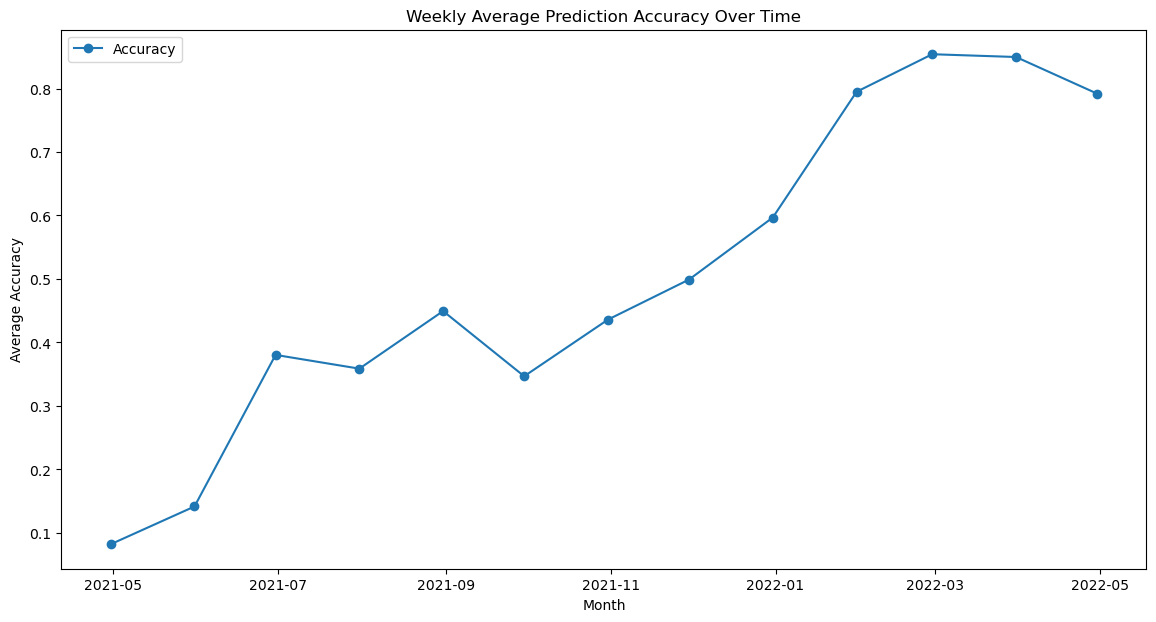

In [52]:
event_dates_test = log_data_encoded.loc[X_test.index, 'event_date'].reset_index(drop=True)
event_dates_test = event_dates_test[:len(actual_labels_LSTM)] 

print(len(event_dates_test))
print(len(actual_labels_LSTM))
print(len(predicted_labels_LSTM))

results_LSTM_df = pd.DataFrame({
    'event_date': event_dates_test,
    'actual_labels': actual_labels_LSTM,
    'predicted_labels': predicted_labels_LSTM
})

results_LSTM_df.index = pd.to_datetime(results_LSTM_df['event_date'])
results_LSTM_df['accuracy'] = (results_LSTM_df['actual_labels'] == results_LSTM_df['predicted_labels']).astype(int)
weekly_accuracy = results_LSTM_df['accuracy'].resample('M').mean()  # Change 'W' to 'M' for monthly

plt.figure(figsize=(14, 7))
plt.plot(weekly_accuracy.index, weekly_accuracy, label='Accuracy', marker='o')
plt.title('Weekly Average Prediction Accuracy Over Time')
plt.xlabel('Month')
plt.ylabel('Average Accuracy')
plt.legend()
plt.show()

              precision    recall  f1-score      support
0              0.000000  0.000000  0.000000     0.000000
1              0.000000  0.000000  0.000000     1.000000
2              0.123902  0.927632  0.218605   152.000000
3              0.049793  0.149068  0.074650   161.000000
4              0.000000  0.000000  0.000000    14.000000
5              0.000000  0.000000  0.000000   439.000000
6              0.000000  0.000000  0.000000    63.000000
7              0.100000  0.045455  0.062500    44.000000
8              0.000000  0.000000  0.000000   108.000000
9              0.000000  0.000000  0.000000     0.000000
10             0.008264  0.500000  0.016260     2.000000
11             0.770042  0.650624  0.705314   561.000000
12             0.873957  0.386347  0.535824  2710.000000
13             0.000000  0.000000  0.000000     0.000000
14             0.877345  0.811749  0.843273   749.000000
15             0.983384  0.859406  0.917224  1515.000000
16             0.433921  0.7010

/Users/Arya/miniforge3/envs/venv-metal/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Arya/miniforge3/envs/venv-metal/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Arya/miniforge3/envs/venv-metal/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(

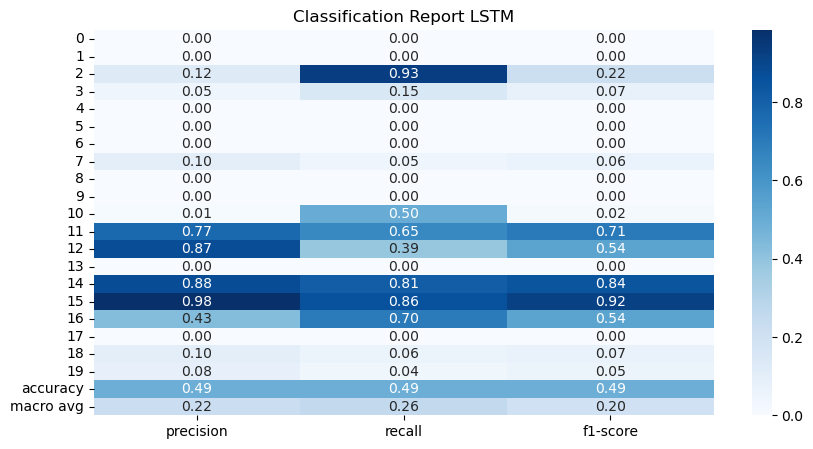

In [53]:
# Classification report
report_LSTM = classification_report(actual_classes_LSTM, y_pred_classes_LSTM, output_dict=True)
report_LSTM_df = pd.DataFrame(report_LSTM).transpose()
print(report_LSTM_df)

plt.figure(figsize=(10, 5))
sns.heatmap(report_LSTM_df.iloc[:-1, :-1], annot=True, fmt=".2f", cmap="Blues")
plt.title('Classification Report LSTM')
plt.show()

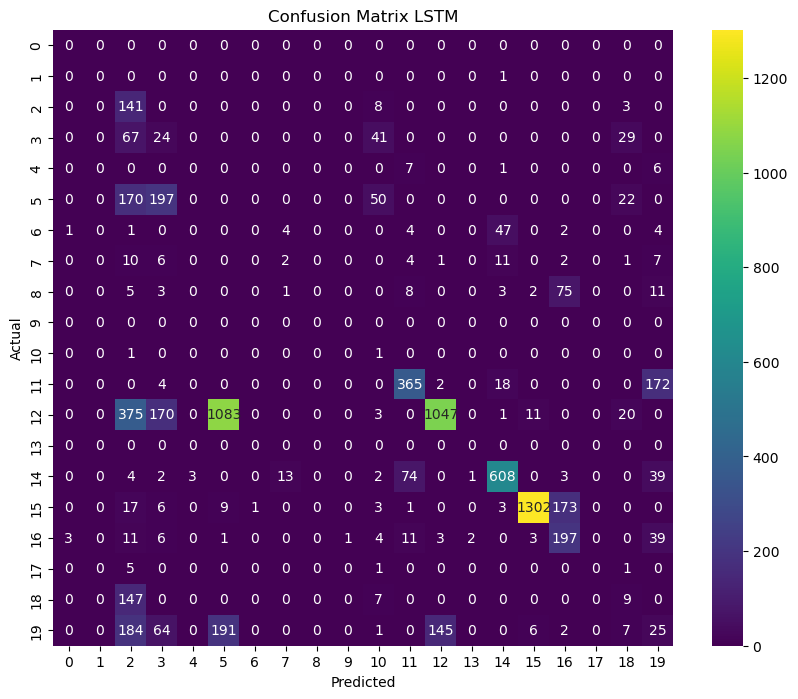

In [54]:
# Confusion Matrix
conf_matrix_LSTM = confusion_matrix(actual_classes_LSTM, y_pred_classes_LSTM)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_LSTM, annot=True, fmt='d', cmap='viridis')  # 'd' for integer format
plt.title('Confusion Matrix LSTM')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

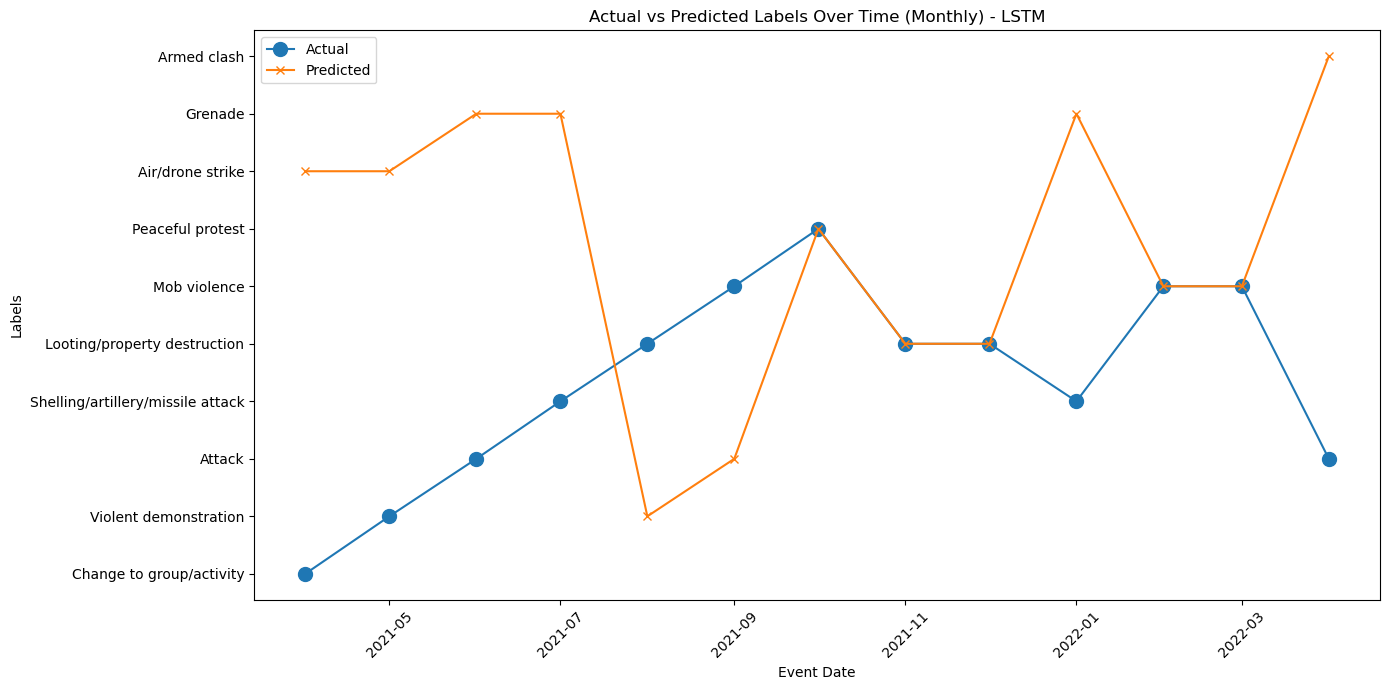

In [55]:
# Reset the index before sorting and converting event_date to monthly period
results_LSTM_df.reset_index(drop=True, inplace=True)
results_LSTM_df.sort_values('event_date', inplace=True)

# Convert event_date to datetime if it's not already
results_LSTM_df['event_date'] = pd.to_datetime(results_LSTM_df['event_date'])

# Extract year and month from event_date
results_LSTM_df['year'] = results_LSTM_df['event_date'].dt.year
results_LSTM_df['month'] = results_LSTM_df['event_date'].dt.month

# Group the data by year and month and get the first value for each group
grouped_results_LSTM_df = results_LSTM_df.groupby(['year', 'month']).first().reset_index()

# Create a new column 'plot_date' with the first day of each month for plotting
grouped_results_LSTM_df['plot_date'] = pd.to_datetime(grouped_results_LSTM_df[['year', 'month']].assign(day=1))

plt.figure(figsize=(14, 7))
plt.plot(grouped_results_LSTM_df['plot_date'], grouped_results_LSTM_df['actual_labels'], label='Actual', marker='o', markersize='10')
plt.plot(grouped_results_LSTM_df['plot_date'], grouped_results_LSTM_df['predicted_labels'], label='Predicted', marker='x')
plt.title('Actual vs Predicted Labels Over Time (Monthly) - LSTM')
plt.xlabel('Event Date')
plt.ylabel('Labels')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

The lines between the dates here represents a form of temporal "tracking" between certain sub-event types and specific months. 

In [51]:
print(results_LSTM_df['event_date'].dt.year.unique())
print(log_data_encoded['event_date'].dt.year.unique())

[2021 2022]
[2024 2023 2022 2021]


In [ ]:
#Grid Search for Hyperparamers - LSTM With Embedding
def create_model(n_features, n_nodes, dropout_rate, n_classes, n_input):
    model = Sequential()
    model.add(Input(shape=(n_input, n_features)))
    model.add(LSTM(n_nodes, return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(n_nodes))
    model.add(Dropout(dropout_rate))
    model.add(Dense(n_classes, activation='softmax'))
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Define configurations
configs = [
    [X_train_reshaped.shape[2], 50, 0.1, 20, X_train_reshaped.shape[1]],  # Testing 10% dropout and 50 neurons, 24 time steps
    [X_train_reshaped.shape[2], 50, 0.2, 20, X_train_reshaped.shape[1]],  # Testing 20% dropout and 50 neurons, 24 time steps
    [X_train_reshaped.shape[2], 100, 0.2, 20, X_train_reshaped.shape[1]],  # Testing 20% dropout and 100 neurons, 24 time steps
    [X_train_reshaped.shape[2], 100, 0.3, 20, X_train_reshaped.shape[1]],  # Testing 30% dropout and 100 neurons, 24 time steps
]

# Function to run model with a specific config
def run_model(config):
    n_features, n_nodes, dropout_rate, n_classes, n_input = config
    model = create_model(n_features, n_nodes, dropout_rate, n_classes, n_input)
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = model.fit(X_train_reshaped, y_train_encoded, epochs=50, batch_size=64, validation_split=0.1, verbose=1, callbacks=[early_stopping])
    _, accuracy = model.evaluate(X_test_reshaped, y_test_encoded, verbose=0)
    return accuracy

# Grid search over configs
best_accuracy = 0
best_config = None
for config in configs:
    accuracy = run_model(config)
    print(f'Config: {config}, Accuracy: {accuracy:.3f}')
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_config = config

print(f'Best Config: {best_config}, Best Accuracy: {best_accuracy:.3f}')

In [ ]:
# Retraining LSTM WITH EMBED
def create_model(n_input, n_features, n_nodes, dropout_rate, n_classes):
    model = Sequential()

    # embedding layer
    model.add(Embedding(input_dim=len(np.unique(y)), output_dim=100, input_length=n_input))
    #flatten?
    model.add(Flatten())

    # LSTM layer
    model.add(LSTM(n_nodes, return_sequences=True))

    # dropout regularization
    model.add(Dropout(dropout_rate))

    # LSTM layer
    model.add(LSTM(n_nodes))

    # dropout regularization
    model.add(Dropout(dropout_rate))

    # output Dense layer with softmax (multi-class classification)
    model.add(Dense(n_classes, activation='softmax'))

    # model with categorical crossentropy loss and Adam optimizer
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# best parameters
best_params = [14, 24, 100, 0.2, 20]  # Assuming n_input is 14 and n_features is 24

# Create and compile the model using the best parameters
LSTM_embed_model_best = create_model(*best_params)

# early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Reshape X_train and X_test to include timesteps
X_train_reshaped = create_sequences(X_train.to_numpy(), best_params[0])
X_test_reshaped = create_sequences(X_test.to_numpy(), best_params[0])

history = LSTM_embed_model_best.fit(X_train_reshaped, y_train_encoded, epochs=50, batch_size=64, validation_split=0.1, verbose=1, callbacks=[early_stopping])

In [ ]:
loss_withembed, accuracy_withembed = LSTM_embed_model_best.evaluate(X_test_reshaped, y_test_encoded)

print(f'Test Accuracy With Embed: {accuracy_withembed:.2f}')

# predictions
y_pred_withembed = LSTM_embed_model_best.predict(X_test_reshaped)
y_pred_classes_withembed = np.argmax(y_pred_withembed, axis=1)

# actual class
actual_classes_withembed = np.argmax(y_test_encoded, axis=1) if y_test_encoded.ndim > 1 else y_test

# showing errors
errors_withembed = np.where(y_pred_classes_withembed != actual_classes_withembed)[0]
print(f'Number of errors With Embed: {len(errors_withembed)} / {len(actual_classes_withembed)}')

for i in errors_withembed[:10]:  # first 10
    print(f'Index: {i}, Predicted: {y_pred_classes_withembed[i]}, Actual: {actual_classes_withembed[i]}')

In [ ]:
predicted_labels_withembed = label_encoders['sub_event_type'].inverse_transform(y_pred_classes_withembed)
actual_labels_withembed = label_encoders['sub_event_type'].inverse_transform(actual_classes_withembed)

for actual, predicted in zip(actual_labels_withembed[:10], predicted_labels_withembed[:10]):
    print(f"Actual: {actual}, Predicted: {predicted}")

In [ ]:
# Accuracy over Time - weekly
results_withembed_df = pd.DataFrame({
    'event_date': log_data_encoded.loc[X_test.index, 'event_date'],
    'actual_labels': actual_labels_withembed,
    'predicted_labels': predicted_labels_withembed
})

results_withembed_df.index = pd.to_datetime(results_withembed_df['event_date'])

# stores prediction was correct
results_withembed_df['correct_prediction'] = (results_withembed_df['actual_labels'] == results_withembed_df['predicted_labels']).astype(int)

# weekly accuracy by taking the mean of pred.
weekly_accuracy_withembed = results_withembed_df['correct_prediction'].resample('W').mean()

plt.figure(figsize=(14, 7))
plt.plot(weekly_accuracy_withembed.index, weekly_accuracy_withembed, label='Accuracy', marker='o')
plt.title('Weekly Average Prediction Accuracy Over Time - With Embed')
plt.xlabel('Week')
plt.ylabel('Average Accuracy')
plt.legend()
plt.show()

In [ ]:
#  Classification report
report_withembed = classification_report(actual_classes_withembed, y_pred_classes_withembed, output_dict=True)
report_withembed_df = pd.DataFrame(report_withembed).transpose()
print(report_withembed_df)

plt.figure(figsize=(10, 5))
sns.heatmap(report_withembed_df.iloc[:-1, :-1], annot=True, fmt=".2f", cmap="Blues")
plt.title('Classification Report Heatmap With Embed')
plt.show()

In [ ]:
# Confusion Matrix
conf_matrix_withembed = confusion_matrix(actual_classes_withembed, y_pred_classes_withembed)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_withembed, annot=True, fmt='d', cmap='viridis')  # 'd' for integer format
plt.title('Confusion Matrix With Embed')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
# Time-Series Plot
if 'event_date' in data.columns:
    event_dates_test_withembed = data.loc[X_test.index, 'event_date']
    results_withembed_df = pd.DataFrame({
        'event_date': event_dates_test_withembed,
        'actual_labels': label_encoders['sub_event_type'].inverse_transform(actual_classes_withembed),
        'predicted_labels': label_encoders['sub_event_type'].inverse_transform(y_pred_classes_withembed)
    })

    results_withembed_df.sort_values('event_date', inplace=True)

    plt.figure(figsize=(14, 7))
    plt.plot(results_withembed_df['event_date'], results_withembed_df['actual_labels'], label='Actual', marker='o')
    plt.plot(results_withembed_df['event_date'], results_withembed_df['predicted_labels'], label='Predicted', marker='x')
    plt.title('Actual vs Predicted Labels Over Time - LSTM With Embed')
    plt.xlabel('Event Date')
    plt.ylabel('Labels')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
# LSTM Model without embedding and NOT ON SELECTED FEATURES

def create_model(n_features, n_nodes, dropout_rate, n_classes):
    model = Sequential()
    model.add(LSTM(n_nodes, return_sequences=True, input_shape=(None, n_features)))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(n_nodes))
    model.add(Dropout(dropout_rate))
    model.add(Dense(n_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Define configurations
configs = [
    [X_original_train.shape[1], 50, 0.1, y_original_train_encoded.shape[1]],  # Testing 10% dropout and 50 neurons
    [X_original_train.shape[1], 50, 0.2, y_original_train_encoded.shape[1]],  # Testing 20% dropout and 50 neurons
    [X_original_train.shape[1], 100, 0.2, y_original_train_encoded.shape[1]],  # Testing 20% dropout and 100 neurons
    [X_original_train.shape[1], 100, 0.3, y_original_train_encoded.shape[1]],  # Testing 30% dropout and 100 neurons
]

# Function to run model with a specific config
def run_model(config):
    n_features, n_nodes, dropout_rate, n_classes = config
    model = create_model(n_features, n_nodes, dropout_rate, n_classes)
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = model.fit(X_original_train, y_original_train_encoded, epochs=50, batch_size=64, validation_split=0.1, verbose=1, callbacks=[early_stopping])
    _, accuracy = model.evaluate(X_original_test, y_original_test_encoded, verbose=0)
    return accuracy

# Grid search over configs
best_accuracy = 0
best_config = None
for config in configs:
    accuracy = run_model(config)
    print(f'Config: {config}, Accuracy: {accuracy:.3f}')
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_config = config

print(f'Best Config: {best_config}, Best Accuracy: {best_accuracy:.3f}')

In [ ]:
# Retraining with best parameters
best_model = create_model(*best_config)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = best_model.fit(X_original_train, y_original_train_encoded, epochs=50, batch_size=64, validation_split=0.1, verbose=1, callbacks=[early_stopping])

loss_noembed, accuracy_noembed = best_model.evaluate(X_original_test, y_original_test_encoded)
print(f'Test Accuracy Without Embed: {accuracy_noembed:.2f}')

In [ ]:
# Predictions
y_pred_noembed = best_model.predict(X_original_test)
y_pred_classes_noembed = np.argmax(y_pred_noembed, axis=1)

# Actual class
actual_classes_noembed = np.argmax(y_original_test_encoded, axis=1)

# Showing errors
errors_noembed = np.where(y_pred_classes_noembed != actual_classes_noembed)[0]
print(f'Number of errors Without Embed: {len(errors_noembed)} / {len(actual_classes_noembed)}')
for i in errors_noembed[:10]:  # first 10
    print(f'Index: {i}, Predicted: {y_pred_classes_noembed[i]}, Actual: {actual_classes_noembed[i]}')


In [ ]:

predicted_labels_noembed = label_encoders['sub_event_type'].inverse_transform(y_pred_classes_noembed)
actual_labels_noembed = label_encoders['sub_event_type'].inverse_transform(actual_classes_noembed)

for actual, predicted in zip(actual_labels_noembed[:10], predicted_labels_noembed[:10]):
    print(f"Actual: {actual}, Predicted: {predicted}")

In [ ]:
# Accuracy over Time - weekly
results_noembed_df = pd.DataFrame({
    'event_date': log_data_encoded.loc[X_original_test.index, 'event_date'],
    'actual_labels': actual_labels_noembed,
    'predicted_labels': predicted_labels_noembed
})
results_noembed_df.index = pd.to_datetime(results_noembed_df['event_date'])
results_noembed_df['correct_prediction'] = (results_noembed_df['actual_labels'] == results_noembed_df['predicted_labels']).astype(int)
weekly_accuracy_noembed = results_noembed_df['correct_prediction'].resample('W').mean()

plt.figure(figsize=(14, 7))
plt.plot(weekly_accuracy_noembed.index, weekly_accuracy_noembed, label='Accuracy', marker='o')
plt.title('Weekly Average Prediction Accuracy Over Time - Without Embed')
plt.xlabel('Week')
plt.ylabel('Average Accuracy')
plt.legend()
plt.show()

In [ ]:
# Classification report
report_noembed = classification_report(actual_classes_noembed, y_pred_classes_noembed, output_dict=True)
report_noembed_df = pd.DataFrame(report_noembed).transpose()
print(report_noembed_df)

plt.figure(figsize=(10, 5))
sns.heatmap(report_noembed_df.iloc[:-1, :-1], annot=True, fmt=".2f", cmap="Blues")
plt.title('Classification Report Heatmap Without Embed')
plt.show()

In [ ]:
# Confusion Matrix
conf_matrix_noembed = confusion_matrix(actual_classes_noembed, y_pred_classes_noembed)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_noembed, annot=True, fmt='d', cmap='viridis')  # 'd' for integer format
plt.title('Confusion Matrix Without Embed')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
# Time-Series Plot
if 'event_date' in data.columns:
    event_dates_test_noembed = data.loc[X_original_test.index, 'event_date']
    results_noembed_df = pd.DataFrame({
        'event_date': event_dates_test_noembed,
        'actual_labels': label_encoders['sub_event_type'].inverse_transform(actual_classes_noembed),
        'predicted_labels': label_encoders['sub_event_type'].inverse_transform(y_pred_classes_noembed)
    })
    results_noembed_df.sort_values('event_date', inplace=True)

    plt.figure(figsize=(14, 7))
    plt.plot(results_noembed_df['event_date'], results_noembed_df['actual_labels'], label='Actual', marker='o')
    plt.plot(results_noembed_df['event_date'], results_noembed_df['predicted_labels'], label='Predicted', marker='x')
    plt.title('Actual vs Predicted Labels Over Time - LSTM Without Embed')
    plt.xlabel('Event Date')
    plt.ylabel('Labels')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
#VAR Model?

#flattening for data purposes
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_val_flat = X_val.reshape(X_val.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

model = VAR(X_train_flat)
model_fitted = model.fit()


In [ ]:
predictions = model_fitted.forecast(model_fitted.y, steps=len(X_val_flat))

mse = mean_squared_error(X_val_flat, predictions)
print("Mean Squared Error:", mse)
plt.plot(X_val_flat, label='Actual')
plt.plot(predictions, label='Predicted')
plt.legend()
plt.show()